In [1]:
from __future__ import print_function
 
from keras.preprocessing import sequence
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,GRU,Conv1D, MaxPooling1D,SpatialDropout1D
from keras.layers.recurrent import LSTM,GRU
from keras.layers.wrappers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.layers import CuDNNGRU
from keras.layers.merge import concatenate, add
from keras.layers import Input,Reshape,Conv2D,MaxPool2D, concatenate

from keras.utils import multi_gpu_model
from keras.models import model_from_json,Model
import numpy as np
import json
import requests
import pandas as pd

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df_all = pd.read_csv('data/19999_question_category_a_v16.csv')
print(f"df_all shape : {df_all.shape}")

df_all shape : (14247, 8)


In [3]:
mapping = df_all.category.astype('category').cat.categories
mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [4]:
from NLP_JiebaSegmentor import JiebaSegmentor
jieba_dict_path1 = "jieba/dict_taiwan.txt"
jieba_dict_path2 = "jieba/userdict.txt"
jieba_dict_path3 = "jieba/dict.txt.big"
jieba_dict_path4 = "jieba/dict.txt.small"
jieba_dict_path5 = "jieba/dict_system.txt"
jieba_stopwords_path = "jieba/stopwords.txt"

js = JiebaSegmentor(dict_path=jieba_dict_path1,
                    userdict=[jieba_dict_path2,
                              jieba_dict_path3,
                              jieba_dict_path4
                              #jieba_dict_path5
                             ],
                    stopwords=True,
                    stopwords_path=jieba_stopwords_path)

Building prefix dict from /project/at081-group3/SourceCode/19999_2RNN/jieba/dict_taiwan.txt ...
Loading model from cache /tmp/jieba.u8f81e49202a03fd1fa71a951575a5172.cache
Loading model cost 0.567 seconds.
Prefix dict has been built succesfully.


In [5]:
test_cut_raw_0 = js.lcut('FTP無法安裝', return_type='pandas')
test_cut_raw_0

,word
0,FTP
1,安裝


In [6]:
# x_train=np.loadtxt("x_train.txt",dtype=int)
# y_train=np.loadtxt("y_train.txt",dtype=int)
 
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)
# x_train = x_train[indices]
# y_train = y_train[indices]
 
# print('Loading data...')
# #x_train=np.loadtxt("x_train.txt",dtype=int)
# #y_train=np.loadtxt("y_train.txt",dtype=int)
# x_test=x_train[20000:]
# y_test=y_train[20000:]
# x_train=x_train[:20000]
# y_train=y_train[:20000]
# #x_test=x_train
# #y_test=y_train
# print(len(x_train), 'train sequences')
# print(len(x_test), 'test sequences')
# print(x_train[:1])
# print('Pad sequences (samples x time)')

In [7]:
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target
0,"無法會員登入,顯示訊息:無效的帳號或使用者不存在。帳號:96122401",CAMP,CAMP,CAMP,CAMP,資訊系統,無法會員登入顯示訊息無效的帳號或不存在帳號,4
1,因今天有事請假，要補登先前的加班，但開啟camp後，出勤表單顯示的內容看起來像測試的，沒有最...,CAMP,CAMP,CAMP,CAMP,資訊系統,因有事請假要補登先前的加班但開啟camp後出勤表單顯示的內容像測試的沒有的時間也沒辦法使用已...,4
2,"手機簽核BPM有問題,都顯示亂碼 #18227",CAMP,CAMP,CAMP,CAMP,資訊系統,簽核bpm有問題都顯示亂碼,4
3,無法在手機上面使用CAMP進行表單簽核動作。分機：17132,CAMP,CAMP,CAMP,CAMP,資訊系統,無法在上面使用camp進行表單簽核動作,4
4,無法打開報單資料,CAMP,CAMP,CAMP,CAMP,資訊系統,無法打開報單資料,4


In [8]:
# w_pandas = js.lcut('無法會員登入 顯示訊息 無效的帳號或不存在 帳號'.strip(), return_type='pandas')
# w_list = list(w_pandas['word'])
# w_list
df_all.groupby(["category"]).size()

category
Outlook與郵件    4123
SAP           1736
其他            1210
網路            5761
資訊系統          1417
dtype: int64

In [9]:
def cut_to_word(s):
    blCondition=True
    w_pandas = js.lcut(s, return_type='pandas')
    w_list = list(w_pandas['word'])
    combie = ''
    combieNO=''
    beforeWord=''
    for i,w in enumerate(w_list):
        if w is ' ':
            continue
        conditionWord = str(combieNO) + str(w)
        
        if combieNO != '' :# and len(conditionWord) == 4:and len(w)>1
            combie = combie + w +','
            combie = combie+combieNO+w
            #print(combieNO+w)
        else:        
            #87.2%=>
            if w in ['修改','顯示','申請單','問題','系統','作業','權限','訊息'] and beforeWord!='' and blCondition :#and len(w)>1
                combie = combie +w+','
                combie = combie+beforeWord+w
            else:
                combie = combie + w
                 
        if i < len(w_list) - 1 and combie !='':
            combie = combie + ','
            
        blAdd = True
        if w in ['無法','不能','電腦','安裝','密碼','下載','上傳','開啟','無線'] and blCondition:#,'安裝','編輯','刪除','新增','作業','忘記','系統','發生','作業','下載','上傳','開啟','安裝']#,'加班','請假','預約','作業'
            combieNO = w
        else:
            combieNO = ''
        beforeWord=w
    return combie    

def cut_to_word2(s):
    w_pandas = js.lcut(s, return_type='pandas')
    w_list = list(w_pandas['word'])
    combie = ''
    for i,w in enumerate(w_list):
        if w is ' ':
            continue
        
        #if len(w)>1:
        combie = combie + w
                 
        if i < len(w_list) - 1:# and len(w)>1:#
            combie = combie + ','
            
    return combie  

# print (cut_to_word('可以幫我聯絡'.strip()))
df_all['cut_words'] = df_all['description_clean'].apply(lambda s: cut_to_word2(s.strip()))


In [10]:
# 資料打散
df_all = df_all.sample(frac=1).reset_index(drop=True)
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
0,"出現RD認證,無法上網",網管,網路,電腦網路不通,網路不斷出現驗證訊息,網路,出現rd認證無法上網,3,"出現,rd,認證,上網"
1,outlook無法開啟 #11100,網管,Outlook與郵件,Outlook,Outlook點不開,Outlook與郵件,outlook,0,outlook
2,user帳號不見了，帳號是:97050531，需要新增，user希望能儘快處理 EXT:1...,SAP-168(QCI),Basis,帳號,帳號無法使用,SAP,帳號不見了帳號是需要新增希望能,1,"帳號,不見了,帳號,需要,新增,希望"
3,"costomer''s Internet ID can''t use, please che...",網管,網路,電腦網路不通,網路不通 (QRDC),網路,costomer''s internet id can''t use please chec...,3,"costomer,s,internet,id,can,t,use,please,check,..."
4,user 反應無線網路問題 #13094,網管,網路,訪客網路,訪客輸入帳號無法成功,網路,無線網路問題,3,"無線網路,問題"


In [11]:
df_all[3040:4010]

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
3040,"我們BU1的重要大客戶Kona(代號)反應, 昨天的email都被退回, 回覆的信息是out...",網管,Outlook與郵件,郵件傳送追蹤,收到退信訊息,Outlook與郵件,bu1的重要大客戶kona代號反應 的都被退回 回覆的信息是outlook只接受內部郵件. ...,0,"bu1,重要,客戶,kona,代號,反應,退回,回覆,信息,outlook,只,接受,內部,..."
3041,無線網路不通,網管,網路,電腦網路不通,網路不通 (QRDC),網路,無線網路不通,3,"無線網路,不通"
3042,"由系統發出的出勤簽核的郵件, 會被歸到垃圾郵件",網管,Outlook與郵件,郵件傳送追蹤,沒有收到某封郵件,Outlook與郵件,由系統發出的出勤簽核的郵件 會被歸到垃圾郵件,0,"系統,發出,出勤,簽核,郵件,到,垃圾郵件"
3043,guest 無法進入網頁。#18973,網管,網路,訪客網路,訪客輸入帳號無法成功,網路,guest 網頁,3,"guest,網頁"
3044,10.241.120.21無法上傳或下載資料請協助處理. EXT:17330,網管,網路,無法連到某台Server,無法連到某些Server,網路,10.241.120.21無法上傳或下載資料.,3,"10.241,120.21,上傳,下載,資料"
3045,"福委會要發中獎公告時, 被卡住",網管,Outlook與郵件,Outlook,其他問題,Outlook與郵件,福委會要發中獎公告時 被卡住,0,"福委會,要發,中獎,公告,時,卡住"
3046,在大陸重新安裝os ，現在網路不通,網管,網路,電腦網路不通,網路不通 (TH20),網路,重新安裝os 現在網路不通,3,"重新安裝,os,現在,網路,不通"
3047,無法收發郵件,網管,Outlook與郵件,Outlook,郵件無法收發,Outlook與郵件,無法收發郵件,0,"收發,郵件"
3048,User無法登入網域，系統顯示:目前無法讓你登入網域,網管,網路,電腦網路不通,無法取得 IP,網路,網域系統顯示目前無法讓你登入網域,3,"網域,系統,顯示,目前,登,入網,域"
3049,outlook漏信(昨晚到今早) 分機: 382-613586,網管,Outlook與郵件,Outlook,其他問題,Outlook與郵件,outlook漏信昨晚到今早,0,"outlook,漏信,昨晚,到,今早"


In [12]:
# 切分資料
X = df_all['cut_words']
y = df_all['category_target']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 40)

In [14]:
X_train.head()

4483                                        有線,無線,不通
2179    出現,quanta,corp2,未經,授權,網際網路,存取,問題,目前,只能靠,無線網路
4810           近日,更改,密碼,後,重新,開機,出現,驗證,失敗,訊息,導致,網路,連線
2209    使用,webmail,outlook,收信,時常,點選,目錄,信件,重新,跳至,登入,頁
5179                     網路,孔,突然,不通,網路,孔,號碼,pm19b283
Name: cut_words, dtype: object

In [15]:
# label 做 onehot
y_train_one_hot = np_utils.to_categorical(y_train)
y_val_one_hot = np_utils.to_categorical(y_val)
print (y_train_one_hot[0])
print (y_val_one_hot[0])
# 總共類別數
num_classes = len((y_train_one_hot[0]))
print ('num_classes = {}'.format(num_classes))

[0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0.]
num_classes = 5


In [16]:
# # 標點符號過濾
# WORD_FILTERS = '!"#$&()*+,-./:;<=>?@[\\]^_{|}~\t\n'
# 字典數量
NUM_WORDS = 5001
# 向量長度
MAX_LEN = 30

token_intent = Tokenizer(num_words=NUM_WORDS,
                        split=",")
# token_intent = Tokenizer(filters=WORD_FILTERS,
#                         num_words=NUM_WORDS,
#                         split=",")

# 斷詞後全部合併丟到fit_on_texts,組出字典
token_intent.fit_on_texts(X_train)
token_intent.fit_on_texts(X_val)

def preprocessing(x, max_len):

    #將文字轉為數字序列
    train_seq_intent = token_intent.texts_to_sequences(x)
    
    #print(char_index)
    # 截長補短，讓所有數字序列長度一樣
    data = sequence.pad_sequences(train_seq_intent, maxlen=MAX_LEN)
    # print train_data_intent.shape
    return data

x_train = preprocessing(X_train, max_len=MAX_LEN)
x_val = preprocessing(X_val, max_len=MAX_LEN)
char_index = token_intent.word_index

In [17]:
x_train

array([[   0,    0,    0, ...,   84,  107,    3],
       [   0,    0,    0, ...,   57, 4894,   10],
       [   0,    0,    0, ...,  163,    1,    7],
       ...,
       [   0,    0,    0, ...,   27,  114,   18],
       [   0,    0,    0, ...,   31,  212,   11],
       [   0,    0,    0, ...,  299,  381, 1828]], dtype=int32)

In [18]:
# set parameters:
max_features = 5001
maxlen = 100
batch_size = 20
embedding_dims = 50
filters = 100
kernel_size = 10
hidden_dims = 250
epochs = 10
train_ratio = 0.9

In [19]:
from keras.layers import Layer
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
 
 
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
 
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
 
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
 
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
 
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
 
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
 
    def build(self, input_shape):
        assert len(input_shape) == 3
 
        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
 
        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
 
        super(AttentionWithContext, self).build(input_shape)
 
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
 
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
 
        if self.bias:
            uit += self.b
 
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
 
        a = K.exp(ait)
 
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
 
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
 
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
 
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [20]:
# https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras import backend as K
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [21]:
#84.6%,83%,84%,83.9%,85%,84%,85.3%,86.2%
from keras.layers import core,BatchNormalization
from keras.layers import CuDNNLSTM
def BidCuDNNLSTM2(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
#     model.add(GRU(128))
    model.add(Bidirectional(CuDNNLSTM(32)))#, return_sequences=True
#    model.add(Attention(30))
#     model.add(Bidirectional(LSTM(128,implementation=2)))
    model.add(Dropout(0.5))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [22]:
#83.8%,83.4%,83.9%,84.8%,84.3%,87.7%
def BidCuDNNLSTM2_Attention(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
#     model.add(GRU(128))
    model.add(Bidirectional(CuDNNLSTM(32, return_sequences=True)))#
    model.add(AttentionWithContext())
#     model.add(Bidirectional(LSTM(128,implementation=2)))
    model.add(Dropout(0.5))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [23]:
#84.7%,88.29%
def BidLSTM_Attention(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
    model.add(LSTM(32,implementation=2, return_sequences=True))
    model.add(AttentionWithContext())
    #model.add(Flatten())
    #model.add(Dense(64,activation='tanh'))
    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(50,activation='tanh'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [24]:
#74.8%#83%,82%,84%,83%,81%
def BidLSTM(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
#     model.add(GRU(128))
    model.add(Bidirectional(LSTM(32)))
#     model.add(Bidirectional(LSTM(128,implementation=2)))

    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [25]:
#79%,83%
def BidCuDNNGRU(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
    model.add(Bidirectional(CuDNNGRU(64)))#
    #model.add(Conv1D(32, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform"))
    #model.add(Attention(29))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [26]:
#70.2%,83.7%,83.18%,83.8%
def BidCuDNNGRU_Attention(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
    model.add(CuDNNGRU(64,return_sequences=True))#
    model.add(Conv1D(32, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform"))
    model.add(AttentionWithContext())
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [27]:
def GRU2(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
    model.add(Bidirectional(CuDNNGRU(64)))#return_sequences=True
    #model.add(Conv1D(32, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform"))
    #model.add(Attention(29))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [28]:
#84%,81.9%
def GRU2_Attention(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
    model.add(GRU(64,return_sequences=True))#
    model.add(Conv1D(32, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform"))
    model.add(AttentionWithContext())
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [29]:
#84.09%,85.5%,84.6%,86%,84.9%,87.8%,86.8%
#https://github.com/jdp527/DL_Text_Classification/blob/master/models/gpu_model.py
#https://aclweb.org/anthology/C16-1329
def blstm_2dcnn(num_classes, max_features, maxlen,embed_size,
               embedding_dropout = .5,
               blstm_units = 1024,
               blstm_dropout = .2,
               cnn_filters = 256,
               cnn_kernel_size = (5,5),
               max_pool_size = (5,5),
               dense_dropout = .5,
               l2_reg = .00001,
               gpus = 2):
    
    '''
    Bidirectional LSTM with Two-dimensional Max Pooling
    
    :param maxlen: max length of sequence
    :param max_features: max number of word embeddings
    :param embed_size: dimension of word embeddings
    :param embedding_matrix: embedding matrix created from embed file
    :param embedding_dropout: dropout after embedding layer
    :param blstm_units: number of lstm units for the biderectional lstm
    :param blstm_dropout: dropout after the blstm layer
    :param cnn_filters: number of CNN filters
    :param cnn_kernel_size: kernel size of the convolution
    :param max_pool_size: max pool size
    :param dense_dropout: dropout before dense layer
    :param l2_reg: l2 kernel regularizer parameter
    :gpus: number of gpus
    :returns: Keras parallel model
    '''
    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, #weights=[embedding_matrix], 
                  input_length=maxlen)(inp)
    x = Dropout(embedding_dropout)(x)    

    x = Bidirectional(CuDNNLSTM(blstm_units, return_sequences=True), merge_mode='sum')(x)
    x = Dropout(blstm_dropout)(x)
    x = Reshape((maxlen, blstm_units, 1))(x)

    x = Conv2D(cnn_filters, kernel_size=cnn_kernel_size, padding='valid', kernel_initializer='glorot_uniform')(x)
    x = MaxPool2D(pool_size=max_pool_size)(x)

    x = Flatten()(x)
    x = Dropout(dense_dropout)(x)
    x = Dense(num_classes, activation = "softmax",  kernel_regularizer=regularizers.l2(l2_reg))(x)
    
    parallel_model = Model(inputs = inp, outputs = x)
    #parallel_model = multi_gpu_model(parallel_model, gpus=gpus)
    parallel_model.summary()
    return parallel_model

In [30]:
#85.2%,85.4%,86%,85.5%,87.9%,87.4%,87.3%,87.5%,88%,87.6%,88.1%,88%,88.8%
def bgru_2dcnn(num_classes, max_features, maxlen,embed_size,
               embedding_dropout = .5,
               bgru_units = 1024,
               bgru_dropout = .2,
               cnn_filters = 256,
               cnn_kernel_size = (5,5),
               max_pool_size = (5,5),
               dense_dropout = .5,
               l2_reg = .00001,
               gpus = 2):
    
    '''
    Bidirectional GRU with Two-dimensional Max Pooling
    
    :param maxlen: max length of sequence
    :param max_features: max number of word embeddings
    :param embed_size: dimension of word embeddings
    :param embedding_matrix: embedding matrix created from embed file
    :param embedding_dropout: dropout after embedding layer
    :param bgru_units: number of gru units for the biderectional gru
    :param bgru_dropout: dropout after the bgru layer
    :param cnn_filters: number of cnn filters
    :param cnn_kernel_size: kernel size of the convolution
    :param max_pool_size: max pool size
    :param dense_dropout: dropout before dense layer
    :param l2_reg: l2 kernel regularizer parameter
    :gpus: number of gpus
    :returns: Keras parallel model
    '''
    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, #weights=[embedding_matrix], 
                  input_length=maxlen)(inp)
    x = Dropout(embedding_dropout)(x)    

    x = Bidirectional(CuDNNGRU(bgru_units, return_sequences=True), merge_mode='sum')(x)
    x = Dropout(bgru_dropout)(x)
    x = Reshape((maxlen, bgru_units, 1))(x)

    x = Conv2D(cnn_filters, kernel_size=cnn_kernel_size, padding='valid', kernel_initializer='glorot_uniform')(x)
    x = MaxPool2D(pool_size=max_pool_size)(x)

    x = Flatten()(x)
    x = Dropout(dense_dropout)(x)
    x = Dense(num_classes, activation = "softmax",  kernel_regularizer=regularizers.l2(l2_reg))(x)
    
    parallel_model = Model(inputs = inp, outputs = x)
    #parallel_model = multi_gpu_model(parallel_model, gpus=gpus)
    #parallel_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return parallel_model

In [31]:
model = GRU2(num_classes, NUM_WORDS, MAX_LEN,32)
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
x_train.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 32)            160032    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               37632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 201,957
Trainable params: 201,957
Non-trainable params: 0
_________________________________________________________________


(11397, 30)

In [32]:
model_path = '{}.h5'.format('19999_rnn')

epochs = 50
batch_size = 32
train_ratio = 0.9

checkpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

model_history = model.fit(x=x_train, y=y_train_one_hot,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_split= 1 - train_ratio
                          ,callbacks = [checkpoint, earlystop]
                         )

Train on 10257 samples, validate on 1140 samples
Epoch 1/50
10257/10257 [==============================] - 4s 394us/step - loss: 0.8453 - acc: 0.6630 - val_loss: 0.5037 - val_acc: 0.8053

Epoch 00001: val_acc improved from -inf to 0.80526, saving model to 19999_rnn.h5
Epoch 2/50
10257/10257 [==============================] - 2s 188us/step - loss: 0.4017 - acc: 0.8653 - val_loss: 0.4369 - val_acc: 0.8482

Epoch 00002: val_acc improved from 0.80526 to 0.84825, saving model to 19999_rnn.h5
Epoch 3/50
10257/10257 [==============================] - 2s 188us/step - loss: 0.2934 - acc: 0.9083 - val_loss: 0.4049 - val_acc: 0.8702

Epoch 00003: val_acc improved from 0.84825 to 0.87018, saving model to 19999_rnn.h5
Epoch 4/50
10257/10257 [==============================] - 2s 186us/step - loss: 0.2272 - acc: 0.9310 - val_loss: 0.3986 - val_acc: 0.8833

Epoch 00004: val_acc improved from 0.87018 to 0.88333, saving model to 19999_rnn.h5
Epoch 5/50
10257/10257 [==============================] - 2s 1

In [33]:
from keras import models
model=models.load_model(model_path)

In [34]:
%pylab inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'add']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


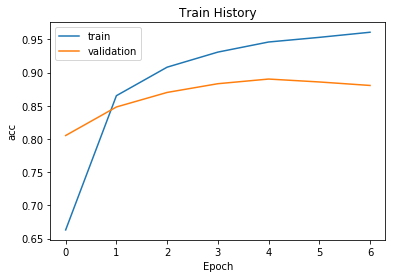

In [35]:
show_train_history(model_history,'acc','val_acc')

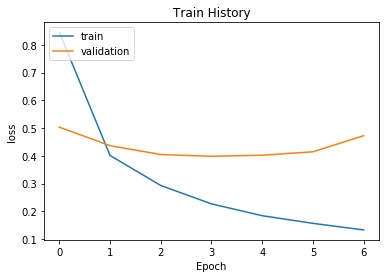

In [36]:
show_train_history(model_history,'loss','val_loss')

In [37]:
def to_cat_name(x): 
        return mapping[x]
    
def predict(test):
#     model = load_model(model_path)
    y_predict_probability = model.predict(test)
    y_predict = model.predict_classes(test)

    return to_cat_name(y_predict), y_predict, y_predict_probability

def predict_class(data):
    y_predict_probability = model.predict(data, batch_size=64, verbose=1)
    predict_arr = []
    predictClass = []
    for row in y_predict_probability: 
            classIndex=0
            selectClass=0
            selectProbability=0
            for item in row: 
                #print(float(item))
                if(selectProbability <= float(item)):
                    #print(classIndex)
                    selectProbability=float(item)
                    selectClass=classIndex
                classIndex=classIndex+1
            predictClass.append(selectClass)
            
    return to_cat_name(predictClass),predictClass,y_predict_probability

y_predict_name, y_predict, y_predict_probability = predict_class(x_val)

2850/2850 [==============================] - 0s 62us/step


In [38]:
answer_name = to_cat_name(y_val)

In [39]:
#model.predict_classes(x_val)

In [40]:
x_val

array([[   0,    0,    0, ..., 2322, 1891,   36],
       [   0,    0,    0, ...,   44, 1796,  418],
       [   0,    0,    0, ...,   23,    3, 3003],
       ...,
       [   0,    0,    0, ...,   38,   13,    5],
       [   0,    0,    0, ...,    0,   10,    7],
       [   0,    0,    0, ...,    0,    7,  651]], dtype=int32)

In [41]:
mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [42]:
# model.predict(x_val)

In [43]:
# predict_df = pd.DataFrame({'1_sentence':df_test.sentence,
#               '2_y_predict':y_predict,
#               '3_y_predict_name':y_predict_name,
#               '4_answer':df_test.target,
#               '5_y_predict_probability':list(y_predict_probability)})
# predict_df

In [44]:
predict_df = pd.DataFrame({
              '1_sentence':X_val,
              '2_y_predict':y_predict,
              '3_y_predict_name':y_predict_name,
              '4_answer':y_val,
              '5_answer_name':answer_name,
              '6_y_predict_probability':list(y_predict_probability)})
# predict_df

In [45]:
# accuracy
accuracy = 1 - (float(len(predict_df[predict_df['2_y_predict'] != predict_df['4_answer']])))/(len(predict_df))
print ('accuracy : {} !!!!!!!!'.format(accuracy))

accuracy : 0.8621052631578947 !!!!!!!!


In [46]:
differ_ans=predict_df[predict_df['2_y_predict'] != predict_df['4_answer']]
differ_ans

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_answer_name,6_y_predict_probability
9363,"傳送,mail,田納西",0,Outlook與郵件,3,網路,"[0.97770613, 6.34891e-06, 0.005104221, 0.01658..."
4599,"調,到,人員,資料",1,SAP,4,資訊系統,"[0.0004080807, 0.8902658, 0.0028951857, 0.0272..."
11704,"live,meeting,會議,號碼,問題",2,其他,0,Outlook與郵件,"[0.07552295, 0.055224966, 0.57177615, 0.164722..."
8910,"電腦,需,檢測,資產,填,nb,檢測,申請單",4,資訊系統,2,其他,"[4.069802e-05, 6.3610455e-06, 0.00077197544, 1..."
7945,"已,申請,軟體,需求單,已,簽核,完成,進行,安裝",4,資訊系統,2,其他,"[0.0027246964, 0.0010573464, 0.066966034, 0.00..."
10478,"康達,館,b3,印表機,上網",3,網路,2,其他,"[0.004089012, 0.09577317, 0.40570465, 0.465419..."
962,"申請,vnc,線上,教學,sd,module",2,其他,1,SAP,"[0.033336744, 0.051623516, 0.7179218, 0.052486..."
3193,"出現,windows,media,player,錯誤,訊息,電腦,裡面,軟體",2,其他,4,資訊系統,"[0.013427746, 0.00034658975, 0.98144823, 0.002..."
13869,"首頁,綁架",3,網路,2,其他,"[0.010988267, 0.05293752, 0.12231006, 0.761699..."
11389,"客戶,要求,亟需,ftpqcafremont,下載,image,檔案,供,sit,驗證,測試...",3,網路,2,其他,"[0.00050911325, 0.00019782328, 0.011096595, 0...."


In [47]:
# confusion matrix
pd.crosstab(np.array(y_predict_name), np.array(answer_name),
            rownames=['predict'], colnames=['answer'])

answer,Outlook與郵件,SAP,其他,網路,資訊系統
predict,,,,,
Outlook與郵件,763,3,29,36,12
SAP,2,267,8,11,17
其他,20,16,152,37,21
網路,27,23,51,1081,21
資訊系統,11,16,19,13,194


In [48]:

# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.h5")
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
# loaded_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# score = loaded_model.evaluate(x_test, y_test, verbose=0)
# print(score)

In [49]:
#pd.DataFrame(differ_ans).to_csv('CNN_v4.csv')